In [1]:
! pip install -r requirements.txt

# MNIST Clustered with Kmeans

We will aim to cluster the MNIST data set, imported from ```sklearn``` using Kmeans. In addition, we will output experiments into folders, including plots, latex formatted tables etc.

## Inititialization

The below code initializes global variables, and anything for outputting the data

In [2]:
import sys, os
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import datetime

def initialize(root, dirs):
    """
    Initialize directories for data outputs.
    Arguments:
        root (str) : the root directory for the program
        dirs (list) : the list of directories to create
    """
    for dr in dirs:
        path = os.path.join(root, dr)
        if not os.path.exists(path):
            os.mkdir(os.path.join(root, dr))

kmeans_dir = 'out_kmeans'
reg_dir = 'out_regression'
clust_dir = 'out_clustering'
data_dirs = [kmeans_dir, reg_dir, clust_dir]
root = sys.path[0]

# create any folders for outputting data.
initialize(root, data_dirs)

## I : Kmeans

We will define some functions to be used in the kmeans analysis. See the docstrings for the function's workings.

In [222]:
def load_npy_arr(fpath):
    """
    Used to load .npy files
    Arguments:
        fpath (str) : the filepath to load
        Return (np.array) : a numpy array for the loaded data
    """

    return np.load(fpath)

def visualize_mnist(features, labels=None, nrows=1, ncols=4, figsize=(10,10), shape=None, title=None, save_path=None, ax_title_templ=None, show=True, hide_last=False):
    """
    Given image array data, plots the images for a given number of rows and columns
    Arguments:
        features : the data for the features
        labels : the data for the labels
        nrows : number of rows in the plots
        ncols : number of columns in the plots
        figsize : the size of the figure to display
        shape (optional, None) : the shape of the image data if it needs to be reshaped 
        title (str) : the title for the top of the plot
        save_path (str) : the path to save the plot to
        ax_title_templ (str) : the template for labelling axes, used in conjunction with labels, or do not pass and format labels entirely
        show (bool) : whether to show the plots in jupyter console
    """
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    if hide_last:
        axes[-1, -1].axis('off')
        
    if title is not None:
        plt.suptitle(title)
    axes = axes.flatten()
    if shape is not None:
        features = np.reshape(features, shape)
    
    if labels is not None:
        for ax, lbl, img in zip(axes, labels, features):
            ax.set_axis_off() # turn off the aves for pretty plots
            ax.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
            if ax_title_templ is not None:
                ax.set_title(ax_title_templ % (lbl))
            else:
                ax.set_title(lbl)
    else:
        for ax, img in zip(axes, features):
            ax.set_axis_off() # turn off the aves for pretty plots
            ax.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
    if save_path is not None:
        plt.savefig(save_path, facecolor="white")
    

    if not show:
        plt.close()

def kmeans_experiment(data, k):
    """
    Applied kmeans algorithm
    Arguments:
        data (np.array) : the data to apply kmeans to
        k (int) : the number of clusters
    Returns:
        : group assignment indices, representative vectors (centroids), and inertia (Jclust) at the end of the experiment
    """
    kmeans = KMeans(n_clusters=k, random_state=0, verbose=0, n_init=1).fit(mnist_train_features)
    return kmeans.labels_, kmeans.cluster_centers_ , kmeans.inertia_

def compare_nearest_points_to_reps(data, k_gr_reps, n_nearest=10, out_path=None, fname_base=None, title_anchor=None):
    """
    Find the nearest 10 data points to each of the k group representatives
    Arguments : 
        data (np.array) : the data to compare distances to k group representatives
        k_gr_representatives (np.array) : the centroids of the clusters
        n_nearest : number of nearest data points to keep track of
    """
    num_data_allowed = 10

    for i, k_gr_rep in enumerate(k_gr_reps):
        distances = []
        row_lookup = {}
        k_and_nearests = [k_gr_rep]
        k_idx = i + 1
        for row in data:
            norm = np.linalg.norm(k_gr_rep - row)
            row_lookup[norm] = row
            distances.append(norm)

        min_dists = np.sort(distances)[:n_nearest]

        for min_dist in min_dists:
            k_and_nearests.append(row_lookup[min_dist])
        ncols = int(n_nearest/5)
        nrows = int(n_nearest/ncols) + 1 # + 1 for the k value 
        title = f"No. {k_idx} K group representative and it's {n_nearest} nearest data points"
        if title_anchor is not None:
            title = title + title_anchor
        labels = []
        for i in range(len(k_and_nearests)):
            if i == 0:
                labels.append(f"K group representative {k_idx}")
            else:
                labels.append(f"No. {i+1} nearest datapoint")
        fname = os.path.join(out_path, fname_base + f"_near{n_nearest}_k_gr_rep{k_idx}")
        print(f"INFO: GENERATING PLOT No. {k_idx} K group representative and it's {n_nearest} nearest data points => {fname}")
        visualize_mnist(features=np.array(k_and_nearests), labels=labels, nrows=nrows, ncols=ncols, shape=(-1, 28, 28), title=title, save_path=fname, show=False, hide_last=True)

Now, we will load the mnist data, which is provided in the project files as a 2D array of shape 7500, 784.

Data is loaded pre-flattened with shape: (7500, 784)
Note the data shape if it was not flattened: (7500, 28, 28)


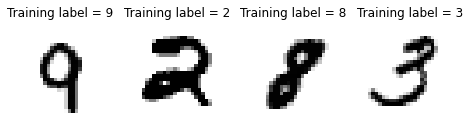

In [223]:
mnist_train_fet_fpath = os.path.join(root, 'train_data.npy')
mnist_train_lbl_fpath = os.path.join(root, 'train_labels.npy')
mnist_test_fet_fpath = os.path.join(root, 'test_data.npy')
mnist_test_lbl_fpath = os.path.join(root, 'test_labels.npy')

mnist_train_features = load_npy_arr(mnist_train_fet_fpath)
mnist_train_labels = load_npy_arr(mnist_train_lbl_fpath)
mnist_test_features = load_npy_arr(mnist_test_fet_fpath)
mnist_test_labels = load_npy_arr(mnist_test_lbl_fpath)
print(f"Data is loaded pre-flattened with shape: {mnist_train_features.shape}")
visualize_mnist(mnist_train_features, labels=mnist_train_labels, nrows=1,ncols=4, figsize=(8, 5), shape=(-1, 28, 28), ax_title_templ="Training label = %s")

print(f"Note the data shape if it was not flattened: {np.reshape(mnist_train_features, (-1, 28, 28)).shape}")

We will now run the experiments for the kmeans algorithm applied to mnist.

The below cell takes approximately 30 seconds to run on my computer, as many figures are created.

## Important Note Regarding Below Cell
I do not output all the plots in the console, and for good reason. I generate over 45 plots in the below cell, so for your convenience plots are generated under a timestamped folder within 'out_kmeans' directory found in the same folder as where you are running this notebook.

The naming convention is as follows:
- j_clust_vs_exp_conf.png: the plot showing the $J^{clust}$ value versus experiment configuration
- maxJ_k5_p10_near10_k_gr_rep1.png: this figure represents a plot of k group representative 1 and it's 10 nearest data points for maximum inertia Kmeans model with k=5 selected from 10 iterations of training.
- maxJ_k5_p10.png: shows all k ground representatives for maximum inertia Kmeans model with k=5 selected from 10 iterations of training.



Launching.. experiment w/ k value '20' @ 30 iterations
Iter 0:
	 k = '20'
	 jclust = 17375154176.0
Iter 1:
	 k = '20'
	 jclust = 17375150080.0
Iter 2:
	 k = '20'
	 jclust = 17375152128.0
Iter 3:
	 k = '20'
	 jclust = 17375150080.0
Iter 4:
	 k = '20'
	 jclust = 17375152128.0
Iter 5:
	 k = '20'
	 jclust = 17375152128.0
Iter 6:
	 k = '20'
	 jclust = 17375150080.0
Iter 7:
	 k = '20'
	 jclust = 17375152128.0
Iter 8:
	 k = '20'
	 jclust = 17375150080.0
Iter 9:
	 k = '20'
	 jclust = 17375152128.0
Iter 10:
	 k = '20'
	 jclust = 17375152128.0
Iter 11:
	 k = '20'
	 jclust = 17375152128.0
Iter 12:
	 k = '20'
	 jclust = 17375152128.0
Iter 13:
	 k = '20'
	 jclust = 17375152128.0
Iter 14:
	 k = '20'
	 jclust = 17375152128.0
Iter 15:
	 k = '20'
	 jclust = 17375152128.0
Iter 16:
	 k = '20'
	 jclust = 17375154176.0
Iter 17:
	 k = '20'
	 jclust = 17375152128.0
Iter 18:
	 k = '20'
	 jclust = 17375152128.0
Iter 19:
	 k = '20'
	 jclust = 17375152128.0
Iter 20:
	 k = '20'
	 jclust = 17375152128.0
Iter 21:
	

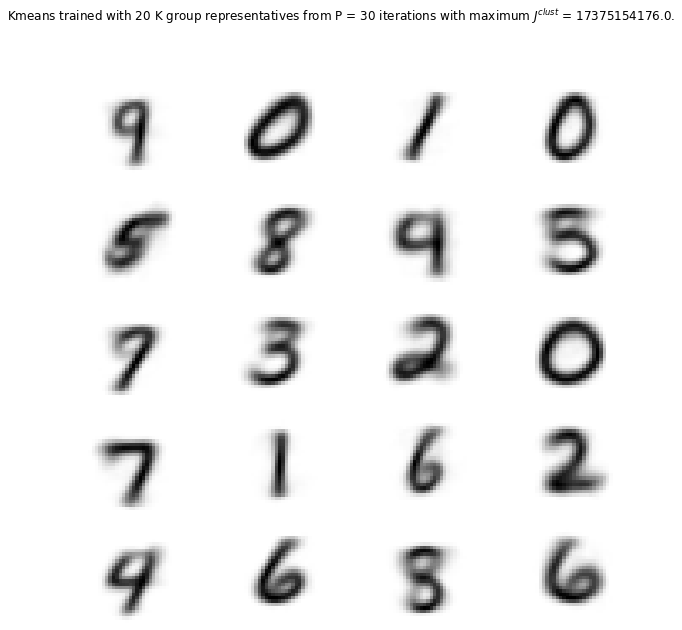

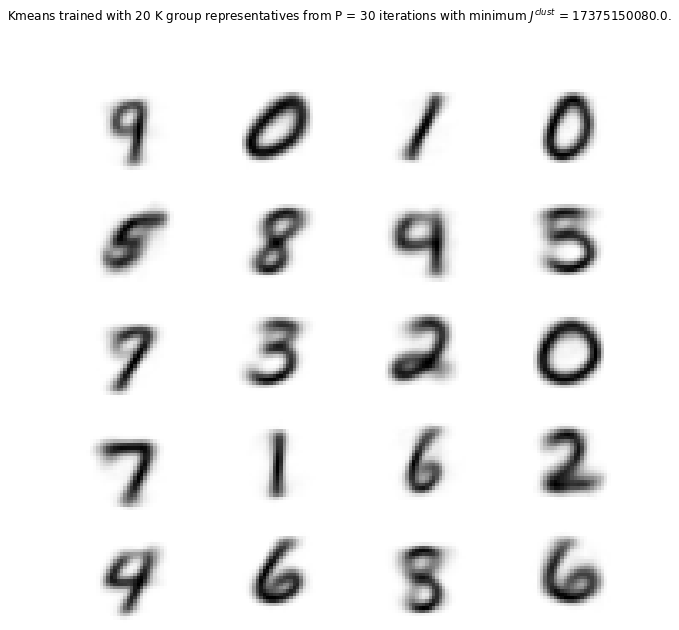

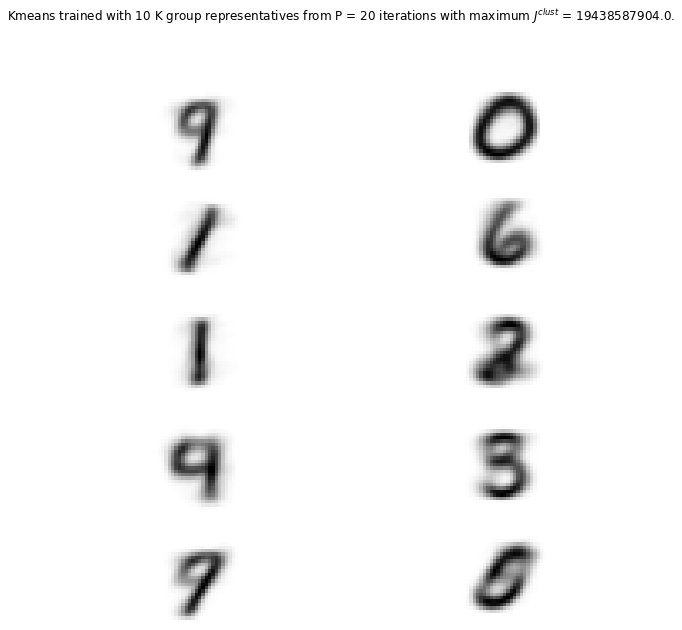

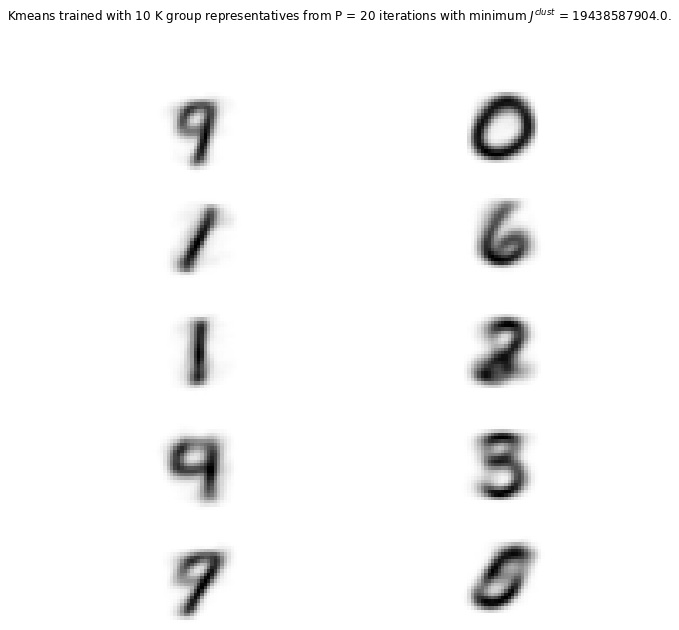

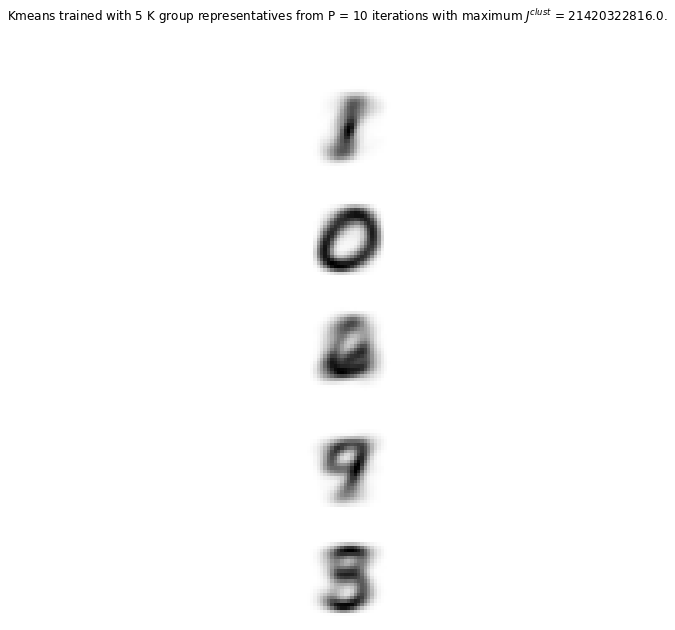

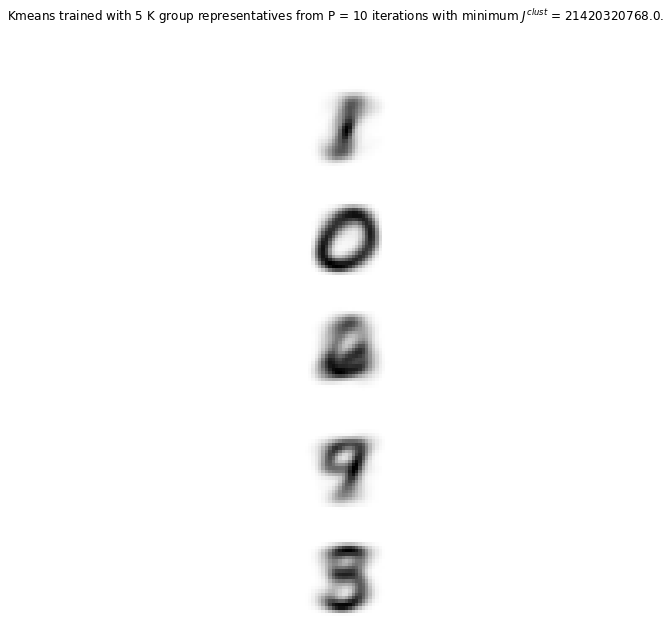

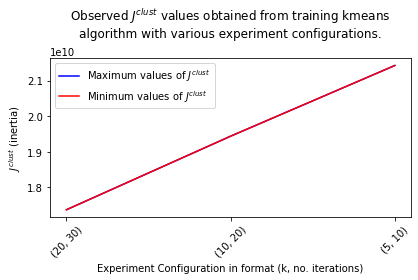

In [237]:
experiment_configuration = [(20, 30), (10, 20), (5, 10)]
# experiment_configuration = [(5, 2), (5, 2), (5, 2)] # uncomment for fast output for testing
exeriment_timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
kmeans_experiment_dir = os.path.join(root, kmeans_dir, exeriment_timestamp)
os.mkdir(kmeans_experiment_dir)
max_inertias = []
min_inertias = []
for k, n_iter in experiment_configuration:
    inertias = []
    gr_assign_idx_list = []
    k_gr_rep_list = []
    print(f"Launching.. experiment w/ k value '{k}' @ {n_iter} iterations")
    for i in range(n_iter):
        gr_assign_idxs, k_gr_reps, inertia = kmeans_experiment(mnist_train_features, k)
        gr_assign_idx_list.append(gr_assign_idxs)
        k_gr_rep_list.append(k_gr_reps)
        inertias.append(inertia)
        print(f"Iter {i}:\n\t k = '{k}'\n\t jclust = {inertia}")
        
    max_inertia = max(inertias)
    min_inertia = min(inertias)

    max_inertia_idx = inertias.index(max_inertia)
    min_inertia_idx = inertias.index(min_inertia)
    gr_assign_idx_max = gr_assign_idx_list[max_inertia_idx]
    gr_assign_idx_min = gr_assign_idx_list[min_inertia_idx]
    k_gr_rep_max = k_gr_rep_list[max_inertia_idx]
    k_gr_rep_min = k_gr_rep_list[min_inertia_idx]
    ncols = int(k/5)
    nrows = int(k/ncols)
    plt_title_templt = "Kmeans trained with %s K group representatives from P = %s iterations with %s $J^{clust}$ = %s."
    output_figname_templt = "%sJ_k%s_p%s"
    plt_title_max = plt_title_templt % (k, n_iter, "maximum", max_inertia)
    max_output_fname = os.path.join(kmeans_experiment_dir, output_figname_templt % ("max", k, n_iter))
    visualize_mnist(features=k_gr_rep_max, nrows=nrows, ncols=ncols, shape=(-1, 28, 28), title=plt_title_max, save_path=max_output_fname)

    plt_title_min = plt_title_templt % (k, n_iter, "minimum", min_inertia)
    min_output_fname = os.path.join(kmeans_experiment_dir, output_figname_templt % ("min", k, n_iter))
    visualize_mnist(features=k_gr_rep_min, nrows=nrows, ncols=ncols, shape=(-1, 28, 28), title=plt_title_min, save_path=min_output_fname)

    # Find the nearest 10 data points to each of the k group representatives
    max_nearest_title_anchor = "\nfor " + plt_title_templt % (k, n_iter, "maximum", max_inertia)
    max_fname_base = output_figname_templt % ("max", k, n_iter)
    compare_nearest_points_to_reps(mnist_train_features, k_gr_rep_max, n_nearest=10, out_path=kmeans_experiment_dir, 
                                   fname_base=max_fname_base, title_anchor=max_nearest_title_anchor)

    min_nearest_title_anchor = "\nfor " + plt_title_templt % (k, n_iter, "minimum", min_inertia)
    min_fname_base = output_figname_templt % ("min", k, n_iter)
    compare_nearest_points_to_reps(mnist_train_features, k_gr_rep_min, n_nearest=10, out_path=kmeans_experiment_dir, 
                                   fname_base=min_fname_base, title_anchor=min_nearest_title_anchor)

    # append info for plotting j_clusts trend for max and min per k and experiment values
    max_inertias.append(max_inertia)
    min_inertias.append(min_inertia)

xvals = np.arange(len(max_inertias))
plt.figure()
plt.plot(xvals, max_inertias, color='blue', label="Maximum values of $J^{clust}$")
plt.plot(xvals, min_inertias, color='red', label="Minimum values of $J^{clust}$")
plt.ylabel("$J^{clust}$ (inertia)")
plt.xticks(xvals, experiment_configuration, rotation=45)
plt.xlabel("Experiment Configuration in format (k, no. iterations)")
plt.title("Observed $J^{clust}$ values obtained from training kmeans \nalgorithm with various experiment configurations.\n")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(kmeans_experiment_dir, 'j_clust_vs_exp_conf'), facecolor='white')

From the last figure above, it is clear that inertia increases and the number of experiments and K values decrease, indicating higher accuracy of the model for high K.

## II : Regression
Our aim here is to load in parking lot data for a city, and try to predict parking lot occupancy over number of days.

We are assuming our dataset has a daily entry for each parking lot. There are 5 parking lots in total, so we will separate the data into those lots and fit regression curves to each lot's data.

Running regression fit for Parking lot 01 with capacity 577
      Parking Number  Capacity  Occupancy
0     Parking lot 01       577         61
1     Parking lot 01       577         64
2     Parking lot 01       577         80
3     Parking lot 01       577        107
4     Parking lot 01       577        150
...              ...       ...        ...
1307  Parking lot 01       577        309
1308  Parking lot 01       577        300
1309  Parking lot 01       577        274
1310  Parking lot 01       577        230
1311  Parking lot 01       577        193

[1312 rows x 3 columns]
Model with:
Coefficients: [-0.00231365]
MSE: 11360.03
r2: -0.00
Running regression fit for Parking lot 02 with capacity 317
      Parking Number  Capacity  Occupancy
0     Parking lot 02       317         93
1     Parking lot 02       317         98
2     Parking lot 02       317        109
3     Parking lot 02       317        116
4     Parking lot 02       317        129
...              ...       ...     

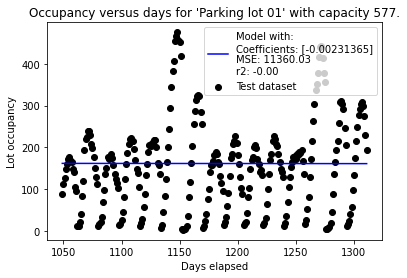

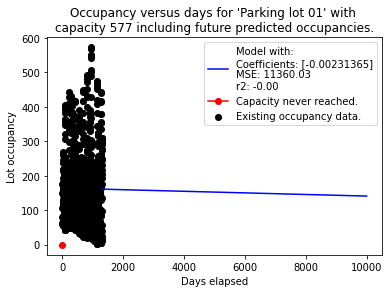

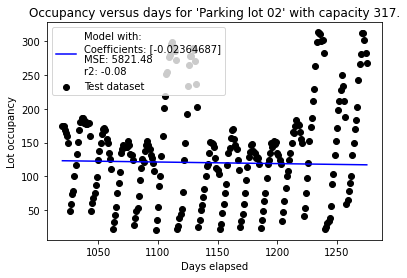

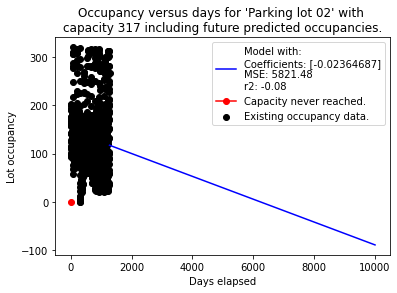

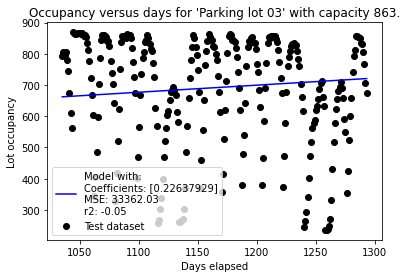

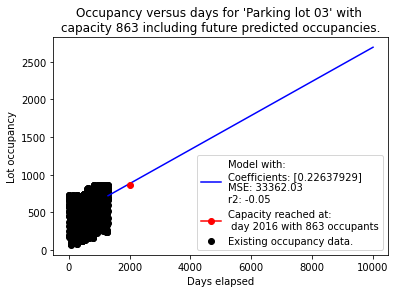

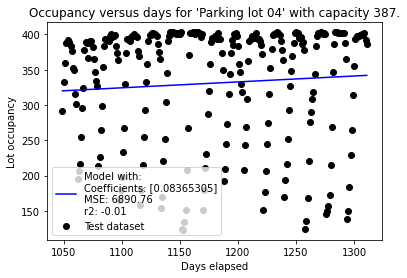

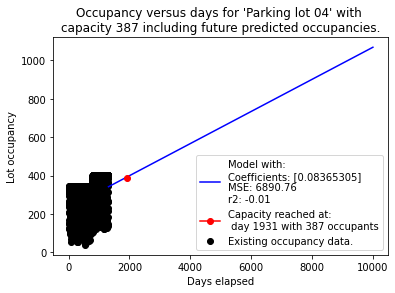

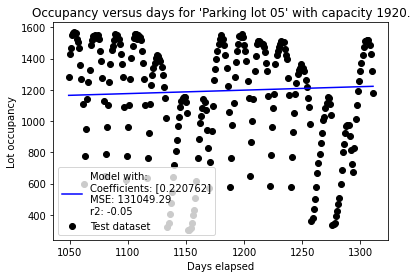

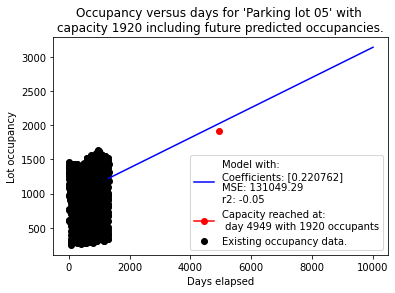

In [252]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
park_data_fname = 'Parking_lots_dataset.csv'

park_data_fpath = os.path.join(root, park_data_fname)

df = pd.read_csv(park_data_fpath)

# splitting data by lot and producing plots
park_dfs = []
exeriment_timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
reg_experiment_dir = os.path.join(root, reg_dir, exeriment_timestamp)
os.mkdir(reg_experiment_dir)

result_table = pd.DataFrame(columns=['Parking Lot Number', "Capacity", "Day Capacity Reached"])
for i in range(5):
    plt.figure()
    idx = i+1
    parking_lot_no  = 'Parking lot 0%s' % (idx)

    # Process the data
    park_df = df[df['Parking Number'] == parking_lot_no]
    park_df = park_df.reset_index(drop=True)
    capacity = park_df['Capacity'][0]
    print("Running regression fit for %s with capacity %s"% (parking_lot_no, capacity))
    print(park_df)
    x_all = park_df.index.to_numpy()
    y_all = park_df['Occupancy'].to_numpy()
    x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, train_size=0.8, shuffle=False)
    x_train = x_train.reshape(-1, 1)
    x_test  = x_test.reshape(-1,1)

    # Fit the model
    lin_regr = linear_model.LinearRegression()
    lin_regr.fit(x_train, y_train)
    y_pred = lin_regr.predict(x_test)

    coefficients = lin_regr.coef_
    mean_sq_err = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    output = "Model with:\nCoefficients: %s\nMSE: %.2f\nr2: %.2f" % (coefficients, mean_sq_err, r2)
    print(output)

    # Plot the evalution plots
    plt.scatter(x_test, y_test, color='black', label="Test dataset")
    plt.plot(x_test, y_pred, color='blue', label=output)
    plt.xlabel('Days elapsed')
    plt.ylabel('Lot occupancy')
    plt.legend()
    title = "Occupancy versus days for '%s' with capacity %s." % (parking_lot_no, capacity)
    plt.title(title)
    plt.savefig(os.path.join(reg_experiment_dir, 'lreg_plot%s_eval' % (idx)), facecolor='white')

    # Plot the prediction plots
    plt.figure()
    x_future = np.linspace(len(x_all), 10000, num=10000).reshape(-1,1)
    y_future = lin_regr.predict(x_future)
    future_title = "Occupancy versus days for '%s' with \ncapacity %s including future predicted occupancies." % (parking_lot_no, capacity)
    values_past_capacity_point = np.where(y_future >= capacity)[0]
    if len(values_past_capacity_point) == 0:
        day_capacity_reached = -1
        occupants_at_capacity_reached = -1
        future_label = "Capacity never reached."

    else:
        future_day_at_capacity  = min(values_past_capacity_point)
        day_capacity_reached =  future_day_at_capacity + len(x_all)
        occupants_at_capacity_reached = y_future[future_day_at_capacity]
        future_label = "Capacity reached at:\n day %s with %d occupants" % (day_capacity_reached, occupants_at_capacity_reached)

    plt.scatter(x_all, y_all, color='black', label="Existing occupancy data.")
    plt.plot(x_future, y_future, color='blue',label = output)
    plt.plot([day_capacity_reached], [occupants_at_capacity_reached], label=future_label, marker='o', color='red')
    plt.xlabel('Days elapsed')
    plt.ylabel('Lot occupancy')
    plt.legend()
    plt.title(future_title)
    plt.savefig(os.path.join(reg_experiment_dir, 'lreg_plot%s_future' % (idx)), facecolor='white')

    # Append results for display, and latex report
    result_table.loc[len(result_table)] = [idx,capacity,day_capacity_reached]

result_table = result_table.sort_values(by=["Day Capacity Reached"])
with open(os.path.join(reg_experiment_dir, 'result_latex.txt'), 'w') as f:  
    print(f"Generated results in latex format {os.path.join(reg_experiment_dir, 'result_latex.txt')}")
    f.write(result_table.to_latex(caption="Regression Summary for Parking Lots", label="tab:regsum"))


In [254]:
output = "\n".join(["Our results are summarized nicely by running the cell below.", 
                   "The parking lots are ranked by concern in ascending order.",
                   "A 'Day Capacity Reached' value of -1 indicates that the model never reaches capacity,",
                   "as the occupancy is decreasing with time.\n"])
print(output)
print(result_table)

print("\n It is clear that parking lots 4,3,5 are the parking lots that will need to be upsized: first 4, then 3, and lastly 5.")
print("We do not need to upgrade parking lot's 1 and 2, as they are decreasing in occupancy with time.")

Our results are summarized nicely by running the cell below.
The parking lots are ranked by concern in ascending order.
A 'Day Capacity Reached' value of -1 indicates that the model never reaches capacity,
as the occupancy is decreasing with time.

  Parking Lot Number Capacity Day Capacity Reached
0                  1      577                   -1
1                  2      317                   -1
3                  4      387                 1931
2                  3      863                 2016
4                  5     1920                 4949

 It is clear that parking lots 4,3,5 are the parking lots that will need to be upsized: first 4, then 3, and lastly 5.
We do not need to upgrade parking lot's 1 and 2, as they are decreasing in occupancy with time.


## III - Clustering Word Problem
The selected store to open from the list is a burger store, such as McDonald's.  It is important to consider the following features when opening a McDonald's store:

- City Location: Location is important as McDonald's restaurants are quite densely distributed in some cities. We would want to order a McDonald's in a city that has few McDonald's locations.
- Diet habit of population: McDonald's does not offer many vegetarian burgers. However clients frequently still buy food at McDonald's. As such, we would want to ensure there is a sufficient population of meat-eaters in the city we choose.
- Religious Beliefs: Some religions do not eat beef, or any meat at all. As such, it is important to consider this factor when trying to successfully launch a profitable McDonald's.
- Lifestyle: Generally, people living fast paced lifestyle are more likely to resort to fast food options. A dense city environment would be quite good.
- Salary: Low income workers/families often resort to fast food options, and providing a McDonald's would diversify their options if one was not present.
- Population Density: Dense cities are ideal for foot traffic into restaurants.

In order to solve this problem, a KMeans clustering approach would be sufficient. I have already produced a program to implement kmeans in the above cells: ```kmeans_experiment()```.

Running ```kmeans_experiment()``` implemented in a loop environment would be great for determining the optimum K for the dataset based on $J^{clust}$ criterion. For example, using a variety of K-values, we can plot the $J_{clust}$ for each given K value and take KMeans model that outputted the lowest inertia.

An example is provided below using the MNIST dataset, running experiments for k=20 at 10 iterations, k=10 at 5 iterations, k=5 at 3 iterations.


Launching.. experiment w/ k value '20' @ 10 iterations
Iter 0:
	 k = '20'
	 jclust = 17375152128.0
Iter 1:
	 k = '20'
	 jclust = 17375152128.0
Iter 2:
	 k = '20'
	 jclust = 17375152128.0
Iter 3:
	 k = '20'
	 jclust = 17375152128.0
Iter 4:
	 k = '20'
	 jclust = 17375152128.0
Iter 5:
	 k = '20'
	 jclust = 17375152128.0
Iter 6:
	 k = '20'
	 jclust = 17375150080.0
Iter 7:
	 k = '20'
	 jclust = 17375150080.0
Iter 8:
	 k = '20'
	 jclust = 17375150080.0
Iter 9:
	 k = '20'
	 jclust = 17375152128.0
Launching.. experiment w/ k value '10' @ 5 iterations
Iter 0:
	 k = '10'
	 jclust = 19438587904.0
Iter 1:
	 k = '10'
	 jclust = 19438587904.0
Iter 2:
	 k = '10'
	 jclust = 19438587904.0
Iter 3:
	 k = '10'
	 jclust = 19438587904.0
Iter 4:
	 k = '10'
	 jclust = 19438587904.0
Launching.. experiment w/ k value '5' @ 3 iterations
Iter 0:
	 k = '5'
	 jclust = 21420320768.0
Iter 1:
	 k = '5'
	 jclust = 21420320768.0
Iter 2:
	 k = '5'
	 jclust = 21420320768.0


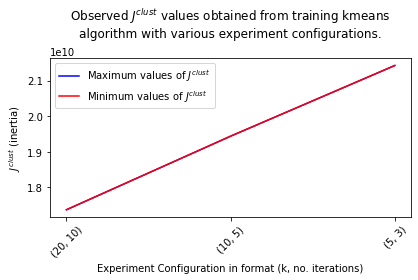

In [255]:
experiment_configuration = [(20, 10), (10, 5), (5, 3)]
max_inertias = []
min_inertias = []
for k, n_iter in experiment_configuration:
    inertias = []
    print(f"Launching.. experiment w/ k value '{k}' @ {n_iter} iterations")
    for i in range(n_iter):
        gr_assign_idxs, k_gr_reps, inertia = kmeans_experiment(mnist_train_features, k)
        inertias.append(inertia)
        print(f"Iter {i}:\n\t k = '{k}'\n\t jclust = {inertia}")
        
    max_inertia = max(inertias)
    min_inertia = min(inertias)
    # append info for plotting j_clusts trend for max and min per k and experiment values
    max_inertias.append(max_inertia)
    min_inertias.append(min_inertia)

xvals = np.arange(len(max_inertias))
plt.figure()
plt.plot(xvals, max_inertias, color='blue', label="Maximum values of $J^{clust}$")
plt.plot(xvals, min_inertias, color='red', label="Minimum values of $J^{clust}$")
plt.ylabel("$J^{clust}$ (inertia)")
plt.xticks(xvals, experiment_configuration, rotation=45)
plt.xlabel("Experiment Configuration in format (k, no. iterations)")
plt.title("Observed $J^{clust}$ values obtained from training kmeans \nalgorithm with various experiment configurations.\n")
plt.legend()
plt.tight_layout()

From the figure generated above, it is clear that the experiment with k=20 at 10 iterations was the optimal experiment with lowest inertia.